<a href="https://colab.research.google.com/github/ejrbdx/Advance-Research-Methods-2024/blob/main/In_class_assignment_2_20_EJR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd '/content/drive/MyDrive/Advanced Research Methods/In class assignments/Class 1 30'

/content/drive/MyDrive/Advanced Research Methods/In class assignments/Class 1 30


In [4]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from skimage import io, transform
from tqdm import tqdm

In [5]:
import os
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

In [6]:
class traffic_sign(Dataset):
    def __init__(self, root_dir ):

        # initialize dataset variables here
        # self.root = root_dir
        self.root = Path(root_dir)

        self.df = pd.DataFrame(columns = ['image_names','class_label'])

        for fldr in self.root.iterdir():
          img_names = []
          if fldr.is_dir():
            img_names = img_names + list(fldr.glob('*.ppm'))

          img_names = [i for i in img_names]
          df_cur = pd.DataFrame(img_names,columns = ['image_names'])
          df_cur['class_label'] = fldr.name
          self.df = pd.concat([self.df, df_cur],axis=0)

        self.df = self.df.sample(frac=1)

        dummies = pd.get_dummies(data = self.df,columns = ['class_label'])
        self.df = self.df.merge(dummies, on = 'image_names')

        self.image_names = list(self.df['image_names'].values)
        self.class_label = self.df.iloc[:,2:].values.tolist()


    def __len__(self):
        # returns the length of the dataset
        return len(self.image_names)

    def __getitem__(self, idx):

        # preprocess and transformations
        # indexes the dataset such that dataset[i] can retrieve the ith sample.
        image = self.image_names[idx]
        # scale = Rescale(256)
        image_data = io.imread(image)
        # image_np = Image.fromarray(image_data)

        label = torch.tensor(self.class_label[idx])

        sample = {'image': image_data, 'label': label}
        scale = Rescale((64,64))
        sample = scale(sample)

        return sample

In [7]:
## transform data
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, labels = sample['image'], sample['label']

        h, w = image.shape[:2]

        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        return {'image': img, 'label': labels}

In [8]:
traffic_sign_dataset = traffic_sign('data/traffic_signs_class')

In [9]:
df_ = traffic_sign_dataset.df
print(df_)

                                         image_names class_label  \
0     data/traffic_signs_class/00034/00012_00024.ppm       00034   
1     data/traffic_signs_class/00033/00021_00024.ppm       00033   
2     data/traffic_signs_class/00034/00002_00007.ppm       00034   
3     data/traffic_signs_class/00040/00006_00019.ppm       00040   
4     data/traffic_signs_class/00033/00021_00007.ppm       00033   
...                                              ...         ...   
1804  data/traffic_signs_class/00034/00008_00003.ppm       00034   
1805  data/traffic_signs_class/00033/00002_00010.ppm       00033   
1806  data/traffic_signs_class/00033/00002_00004.ppm       00033   
1807  data/traffic_signs_class/00029/00008_00018.ppm       00029   
1808  data/traffic_signs_class/00034/00013_00016.ppm       00034   

      class_label_00029  class_label_00033  class_label_00034  \
0                     0                  0                  1   
1                     0                  1           

In [10]:
# dummies = pd.get_dummies(data = df_,columns = ['class_label'])
# df_ = df_.merge(dummies, on = 'image_names')
# print(dummies)

In [11]:
traffic_sign_dataset[10]['image'].reshape(-1,1).shape

(12288, 1)

In [12]:
traffic_sign_dataset[20]['label']

tensor([1, 0, 0, 0])

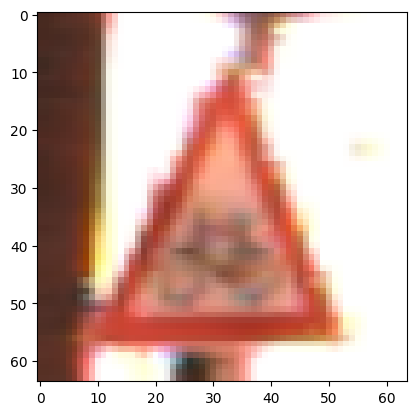

In [13]:
plt.imshow(traffic_sign_dataset[10]['image'])

In [14]:
for i, sample in enumerate(traffic_sign_dataset):
  print(i, sample['image'].shape, sample['label'])
  if i == 3:
    break

0 (64, 64, 3) tensor([0, 0, 1, 0])
1 (64, 64, 3) tensor([0, 1, 0, 0])
2 (64, 64, 3) tensor([0, 0, 1, 0])
3 (64, 64, 3) tensor([0, 0, 0, 1])


In [15]:
class ToTensor(object):
    def __call__(self, sample):
        input, output = sample['image'], sample['label']

        return {'image': torch.tensor(np.array(input),dtype=torch.float32).reshape(16,-1),
                'label': torch.tensor(output,dtype=torch.float32).reshape(16,-1)}

In [19]:
ts = ToTensor()

In [20]:
bs = 16

dataloader = DataLoader(traffic_sign_dataset, batch_size=bs, shuffle=True, num_workers=4,drop_last=True)


In [21]:
## how will we add softmax to this
model = nn.Sequential(
        nn.Linear(12288, 256),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, 4),
        nn.Softmax()
        )


In [22]:
for i, sample in enumerate(dataloader):
  # print (sample['image'].size())
  sample = ts(sample)
  print (sample['image'].size(), sample['label'].size())
  if i == 2:
    break

torch.Size([16, 12288]) torch.Size([16, 4])
torch.Size([16, 12288]) torch.Size([16, 4])
torch.Size([16, 12288]) torch.Size([16, 4])


In [23]:
criterion = nn.CrossEntropyLoss()
# criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [90]:
mean_loss = []
losses = []
test_losses = []
mean_test_loss = []
ts = ToTensor()
n_epochs = 10
acc = []
for it in tqdm(range(n_epochs)):
  # zero the parameter gradients
  for i_batch, sample_batched in enumerate(dataloader):
    optimizer.zero_grad()
    sample_batched = ts(sample_batched)
    outputs = model(sample_batched['image'])
    loss = criterion(outputs, sample_batched['label'])
    losses.append(loss.item())

    for idx, x in enumerate(sample_batched):
      rout = torch.round(outputs[idx])
      targets = sample_batched['label'][idx]
      real = max((v,i) for i, v in enumerate(targets))[1]
      test = max((v,i) for i, v in enumerate(rout) )[1]

      if real == test: # in the case would it be 100% accurate or 0% since it should only have one value in the list? I know usually it's a probably so not sure if this what I want.
        acc_ = 100
      else:
        acc_ = 0
    acc.append(acc_)
    loss.backward()
    optimizer.step()
    mean_loss.append(np.mean(losses))

  print(f'Epoch {it+1}/{n_epochs}, Training Loss: {np.mean(losses):.4f}')


 10%|█         | 1/10 [00:20<03:06, 20.73s/it]

Epoch 1/10, Training Loss: 1.3294


 20%|██        | 2/10 [00:41<02:47, 20.99s/it]

Epoch 2/10, Training Loss: 1.3297


 30%|███       | 3/10 [01:00<02:19, 19.95s/it]

Epoch 3/10, Training Loss: 1.3296


 40%|████      | 4/10 [01:21<02:02, 20.35s/it]

Epoch 4/10, Training Loss: 1.3295


 50%|█████     | 5/10 [01:42<01:42, 20.54s/it]

Epoch 5/10, Training Loss: 1.3296


 60%|██████    | 6/10 [02:01<01:20, 20.04s/it]

Epoch 6/10, Training Loss: 1.3297


 70%|███████   | 7/10 [02:22<01:00, 20.28s/it]

Epoch 7/10, Training Loss: 1.3297


 80%|████████  | 8/10 [02:41<00:39, 19.97s/it]

Epoch 8/10, Training Loss: 1.3297


 90%|█████████ | 9/10 [03:01<00:20, 20.07s/it]

Epoch 9/10, Training Loss: 1.3298


100%|██████████| 10/10 [03:21<00:00, 20.12s/it]

Epoch 10/10, Training Loss: 1.3297


In [91]:
print(acc)
#I kind of did it but I feel like this isn't what you are looking for

[100, 100, 0, 0, 100, 0, 0, 0, 100, 0, 0, 0, 0, 100, 100, 0, 0, 100, 100, 0, 100, 0, 100, 0, 100, 100, 0, 0, 0, 0, 0, 0, 100, 0, 100, 0, 0, 100, 0, 0, 100, 0, 100, 100, 100, 100, 100, 0, 100, 0, 100, 0, 100, 100, 100, 0, 0, 0, 0, 0, 100, 0, 100, 100, 0, 0, 0, 0, 0, 100, 100, 0, 100, 100, 100, 0, 0, 100, 0, 0, 100, 0, 0, 0, 100, 0, 0, 100, 100, 100, 100, 0, 0, 100, 0, 0, 0, 0, 0, 100, 100, 100, 0, 0, 0, 0, 0, 0, 0, 100, 0, 0, 0, 0, 100, 0, 0, 100, 100, 0, 0, 0, 100, 0, 100, 100, 0, 0, 0, 0, 100, 0, 0, 100, 0, 100, 100, 100, 100, 0, 0, 0, 100, 100, 0, 100, 100, 0, 100, 100, 0, 100, 0, 0, 0, 100, 100, 0, 100, 100, 100, 0, 100, 0, 100, 100, 100, 100, 0, 100, 0, 0, 0, 100, 100, 100, 0, 0, 0, 0, 0, 0, 100, 100, 100, 100, 0, 0, 0, 100, 0, 0, 0, 0, 100, 100, 100, 100, 100, 100, 0, 100, 100, 100, 0, 0, 100, 100, 0, 100, 0, 0, 0, 100, 100, 0, 0, 0, 0, 0, 100, 0, 100, 100, 100, 0, 100, 100, 0, 100, 100, 0, 0, 0, 100, 0, 100, 0, 100, 100, 100, 100, 100, 0, 0, 0, 0, 0, 100, 0, 100, 100, 100, 0, 100

In [92]:
torch.save(model.state_dict(), 'traffic_model.pt')

In [29]:
## load saved model
model_arch = nn.Sequential(
        nn.Linear(12288, 256),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, 4)
        )
model_arch.load_state_dict(torch.load('traffic_model.pt'))
model_arch.eval()

Sequential(
  (0): Linear(in_features=12288, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=128, bias=True)
  (3): ReLU()
  (4): Linear(in_features=128, out_features=64, bias=True)
  (5): ReLU()
  (6): Linear(in_features=64, out_features=4, bias=True)
)

In [30]:
ts = ToTensor()
for i_batch, sample_batched in enumerate(dataloader):
      sample_batched = ts(sample_batched)
      outputs = model(sample_batched['image'])
      # outputs
      print (outputs.reshape(-1).tolist())
      print (sample_batched['label'].reshape(-1).tolist())
      print ('######')

[0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 3.928005303948512e-26, 1.0, 8.527736762049195e-26, 1.0917340657597876e-25, 0.0, 1.0, 0.0, 0.0, 3.0317523776943017e-33, 1.0, 8.792097507347822e-33, 1.1476246287270388e-32, 0.0, 1.0, 4.203895392974451e-45, 4.203895392974451e-45, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 5.5554342877344014e-27, 1.0, 1.1756907138245924e-26, 1.6384671816319525e-26, 1.299770466948784e-38, 1.0, 3.9103847415711395e-38, 6.47829584679166e-38, 5.271996654521955e-33, 1.0, 1.4960312360771798e-32, 1.983643925213527e-32, 2.1052555309953064e-25, 1.0, 4.43855300031964e-25, 5.5662375529421285e-25, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]
[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 